In [1]:
%load_ext autoreload
%autoreload 2

import sys
import json
import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from scipy.stats import spearmanr, pearsonr
from scipy.stats import entropy
from scipy.special import softmax

sys.path.append('..')
sys.path.append('pLMtrainer')
from pLMtrainer import utils

parquet_path = "../data/frustration/v8_frustration_v2.parquet.gzip"

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
test_set = np.load("../data/it5_ABL_protT5_CW_LORA/test_preds.npz")
test_set.files

FileNotFoundError: [Errno 2] No such file or directory: '../data/it5_ABL_protT5_CW_LORA/test_preds.npz'

In [3]:
test_set = {key: test_set[key] for key in test_set.files}
test_set.keys()

dict_keys(['full_seqs', 'masks', 'regr_preds', 'cls_preds', 'regr_targets', 'cls_targets', 'masked_regr_preds', 'masked_cls_preds', 'masked_regr_targets', 'masked_cls_targets', 'cls_preds_logits', 'masked_cls_preds_logits'])

In [4]:
#adding masked residues
padded_seqs = []
for seq in test_set["full_seqs"]:
    if len(seq) < 512:
        # Pad the sequence
        padding = "X" * (512 - len(seq))
        padded_seqs.append(seq + padding)
    else:
        # Truncate the sequence
        padded_seqs.append(seq[:512])
padded_seqs = np.array(padded_seqs)
seq_array = np.array([list(seq) for seq in padded_seqs])
test_set["masked_residues"] = seq_array[test_set["masks"]]

### FIG1 

### FIG2

In [8]:
# load the dictionaries for later use
with open('../data/frustration/reg_heuristic.json', 'r') as f:
    reg_dict = json.load(f)
with open('../data/frustration/cls_heuristic.json', 'r') as f:
    cls_dict = json.load(f)

In [9]:
mean_regr_preds = np.array([reg_dict[res]["mean"] for res in test_set["masked_residues"]])
majority_cls_preds = np.array([cls_dict[res]["majority_class"] for res in test_set["masked_residues"]])

In [10]:
res_df = pd.DataFrame({"regr_pred": test_set["masked_regr_preds"],
                       "true_reg": test_set["masked_regr_targets"],
                       "cls_pred": test_set["masked_cls_preds"],
                       "cls_target": test_set["masked_cls_targets"],
                       "residue": test_set["masked_residues"],
                       "mean_residue_frst": mean_regr_preds,
                       "majority_cls_preds": majority_cls_preds
                       })
res_df.head()

,regr_pred,true_reg,cls_pred,cls_target,residue,mean_residue_frst,majority_cls_preds
0,-0.160256,0.200,1,1,S,-0.380689,1
1,-0.183141,-0.313,1,1,S,-0.380689,1
2,-0.002565,-0.224,1,1,T,-0.120997,1
3,0.918370,1.238,2,2,V,1.202699,2
4,-0.503789,-0.518,1,1,G,-0.332914,1


In [11]:
res_df_sub = res_df.sample(100000, random_state=42)

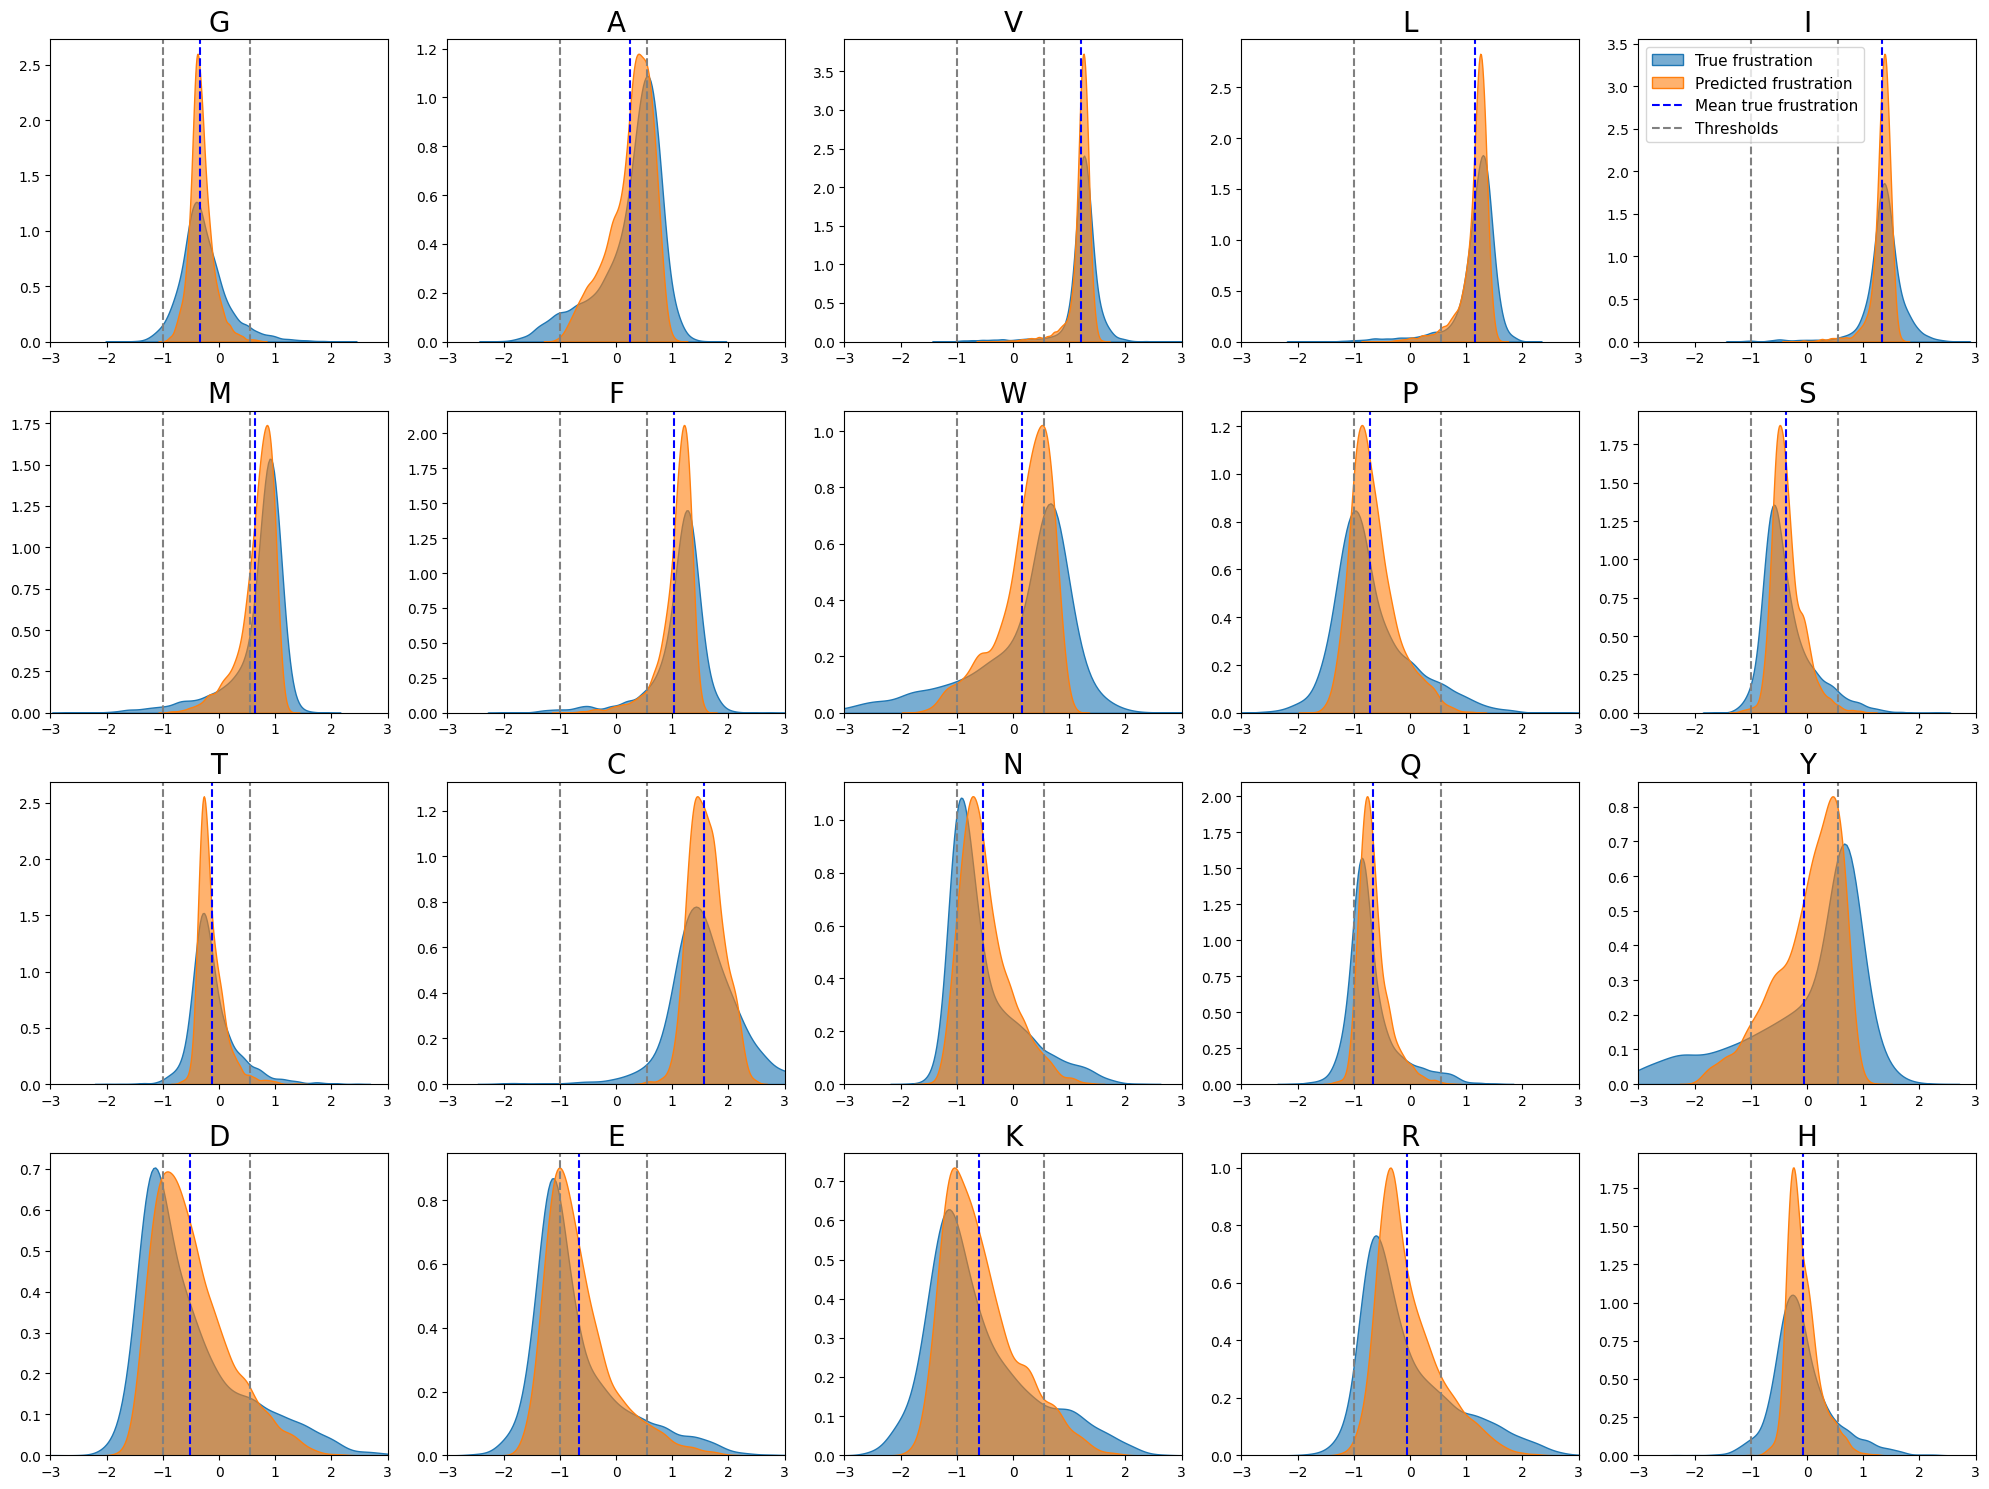

In [12]:
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
residues = res_df_sub["residue"].unique()
residues = ["G", "A", "V", "L", "I", "M", "F", "W", "P", "S", "T", "C", "N", "Q", "Y", "D", "E", "K", "R", "H"]
plt_legend = False
for i, residue in enumerate(residues):
    if residue == "I":
        plt_legend = True
    ax = axes[i // 5, i % 5]
    subset = res_df_sub[res_df_sub["residue"] == residue]
    res = subset["residue"].unique()[0]
    sns.kdeplot(data=subset, x="true_reg", ax=ax, color="C0", alpha=0.6, fill=True, label="True frustration")
    sns.kdeplot(data=subset, x="regr_pred", ax=ax, color="C1", alpha=0.6, fill=True, label="Predicted frustration")
    ax.axvline(reg_dict[res]["mean"], color="blue", linestyle="--", label="Mean true frustration")
    ax.axvline(-1, color="gray", linestyle="--", label="Thresholds")
    ax.axvline(0.55, color="gray", linestyle="--")
    ax.set_xlim(-3, 3)
    ax.set_title(f'{residue}', fontsize=20)

    #ax.set_xlabel("Frustration")
    #ax.set_ylabel("Density")
    ax.set_xlabel("")
    ax.set_ylabel("")
    if plt_legend:
        plt_legend = False
        ax.legend(fontsize=11, loc="upper left")
plt.tight_layout()
plt.show()

In [13]:
# custom order
custom_order = ['P','Q','E','K','N','D','R','S','G','T','H','Y','W','A','M','F','L','V','I','C'] 

In [14]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# --- Order residues ---
#residues = ["G", "A", "V", "L", "I", "M", "F", "W", "P", "S",
#            "T", "C", "N", "Q", "Y", "D", "E", "K", "R", "H"]
residues = custom_order
# --- Add an ordering column so FacetGrid keeps your order ---
res_df_sub["residue"] = pd.Categorical(res_df_sub["residue"], categories=residues, ordered=True)
# Melt dataframe so ridgeplot can handle two distributions
df_melt = res_df_sub.melt(
    id_vars=["residue"],
    value_vars=["true_reg", "regr_pred"],
    var_name="type",
    value_name="frustration",
)

In [15]:
df_melt["frustration"] = df_melt["frustration"].clip(-2, 1.55)
df_melt["frustration"].max(), df_melt["frustration"].min()

(np.float32(1.55), np.float32(-2.0))

In [16]:
df_melt_1 = df_melt[df_melt["residue"].isin(custom_order[:10])].copy()
df_melt_2 = df_melt[df_melt["residue"].isin(custom_order[10:])].copy()
df_melt_1 = df_melt_1.reindex()
df_melt_2 = df_melt_2.reindex()
df_melt_1.shape, df_melt_2.shape

((107772, 3), (92228, 3))

In [17]:
# remove used categories from df_melt_1 and df_melt_2
df_melt_1["residue"] = df_melt_1["residue"].cat.remove_unused_categories()
df_melt_2["residue"] = df_melt_2["residue"].cat.remove_unused_categories()

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


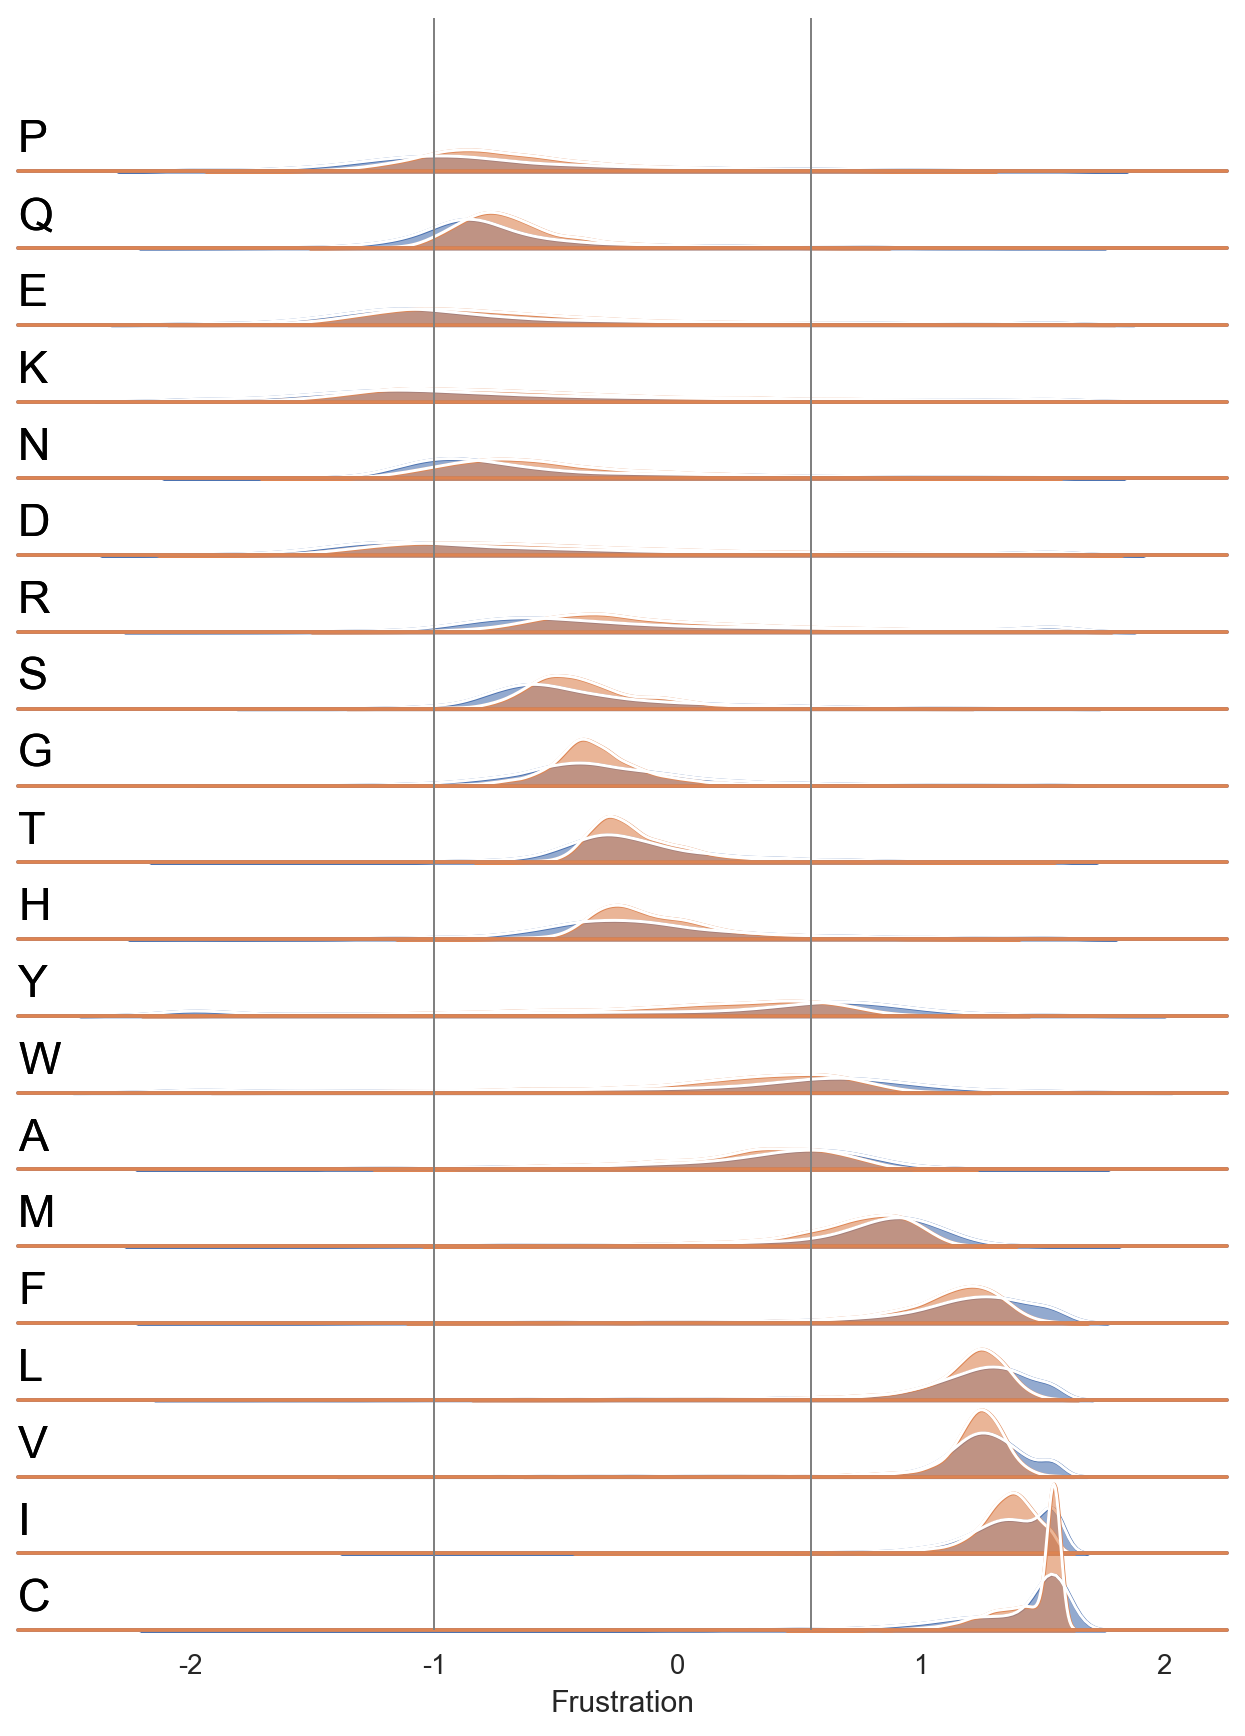

In [18]:
# Color palette for true vs predicted frustration
palette = {"true_reg": "C0", "regr_pred": "C1"}

# --- Ridge plot setup ---
g = sns.FacetGrid(df_melt,row="residue",hue="type",aspect=15,height=0.5,palette=palette,)

# KDEs
g.map(sns.kdeplot,"frustration",bw_adjust=0.8,clip_on=False,fill=True,alpha=0.6,linewidth=1.5,)

# White outline on top
g.map(sns.kdeplot,"frustration",clip_on=False,color="white",lw=1.2,bw_adjust=0.8,)

# Zero baseline for overlap
g.refline(y=0, linewidth=1.5, linestyle="-", color=None, clip_on=False)

# Optional: Add residue label on each ridge
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

def label_residue(x, color, label):
    ax = plt.gca()
    # Determine which residue corresponds to this axis
    row_i = ax.get_subplotspec().rowspan.start
    residue_name = residues[row_i]  # residues is your ordered list
    ax.text(
        0, 0.2, residue_name,
        ha="left", va="center",
        fontsize=18, color="black",
        transform=ax.transAxes
    )

g.map(label_residue, "frustration")

# Optional: Add vertical threshold lines & mean lines
def add_lines(x, color, label):
    ax = plt.gca()
    res = label  # because FacetGrid passes residue as "label"

    # thresholds
    ax.axvline(-1, color="gray", linestyle="-", linewidth=0.7)
    ax.axvline(0.55, color="gray", linestyle="-", linewidth=0.7)

    # mean true frustration for this residue
    #mean_val = reg_dict[res]["mean"]
    #ax.axvline(mean_val, color="blue", linestyle="--", linewidth=1)

g.map(add_lines, "frustration")

# Formatting
g.figure.subplots_adjust(hspace=-0.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Frustration", xticks=np.arange(-2, 3, 1), xticklabels=[-2, -1, 0, 1, 2])
g.despine(bottom=True, left=True)
g.figure.set_dpi(180)

plt.show()

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

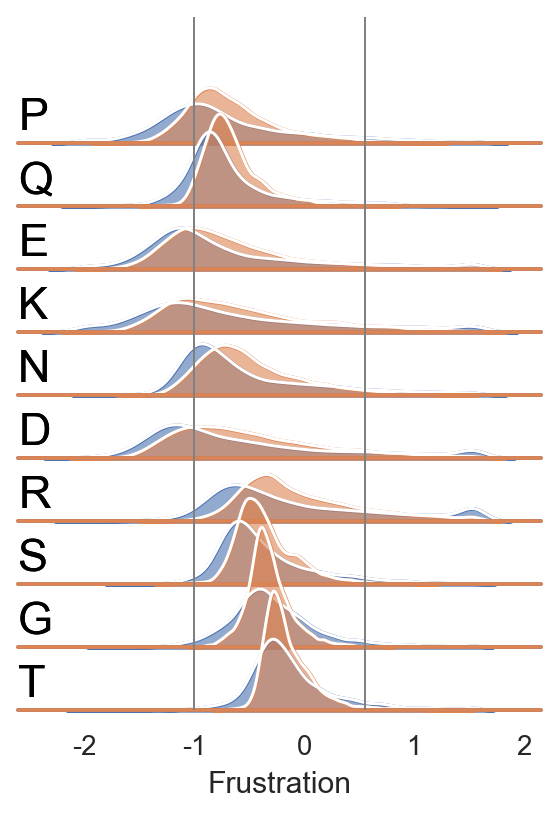

In [19]:
# Color palette for true vs predicted frustration
palette = {"true_reg": "C0", "regr_pred": "C1"}

# --- Ridge plot setup ---
g = sns.FacetGrid(df_melt_1,row="residue",hue="type",aspect=7.5,height=0.5,palette=palette,)

# KDEs
g.map(sns.kdeplot,"frustration",bw_adjust=0.8,clip_on=False,fill=True,alpha=0.6,linewidth=1.5,)

# White outline on top
g.map(sns.kdeplot,"frustration",clip_on=False,color="white",lw=1.2,bw_adjust=0.8,)

# Zero baseline for overlap
g.refline(y=0, linewidth=1.5, linestyle="-", color=None, clip_on=False)

# Optional: Add residue label on each ridge
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

def label_residue(x, color, label):
    ax = plt.gca()
    # Determine which residue corresponds to this axis
    row_i = ax.get_subplotspec().rowspan.start
    residue_name = residues[row_i]  # residues is your ordered list
    ax.text(
        0, 0.2, residue_name,
        ha="left", va="center",
        fontsize=18, color="black",
        transform=ax.transAxes
    )

g.map(label_residue, "frustration")

# Optional: Add vertical threshold lines & mean lines
def add_lines(x, color, label):
    ax = plt.gca()
    res = label  # because FacetGrid passes residue as "label"

    # thresholds
    ax.axvline(-1, color="gray", linestyle="-", linewidth=0.7)
    ax.axvline(0.55, color="gray", linestyle="-", linewidth=0.7)

    # mean true frustration for this residue
    #mean_val = reg_dict[res]["mean"]
    #ax.axvline(mean_val, color="blue", linestyle="--", linewidth=1)

g.map(add_lines, "frustration")

# Formatting
g.figure.subplots_adjust(hspace=-0.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Frustration", xticks=np.arange(-2, 3, 1), xticklabels=[-2, -1, 0, 1, 2])
g.despine(bottom=True, left=True)
g.figure.set_dpi(180)

plt.show()

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

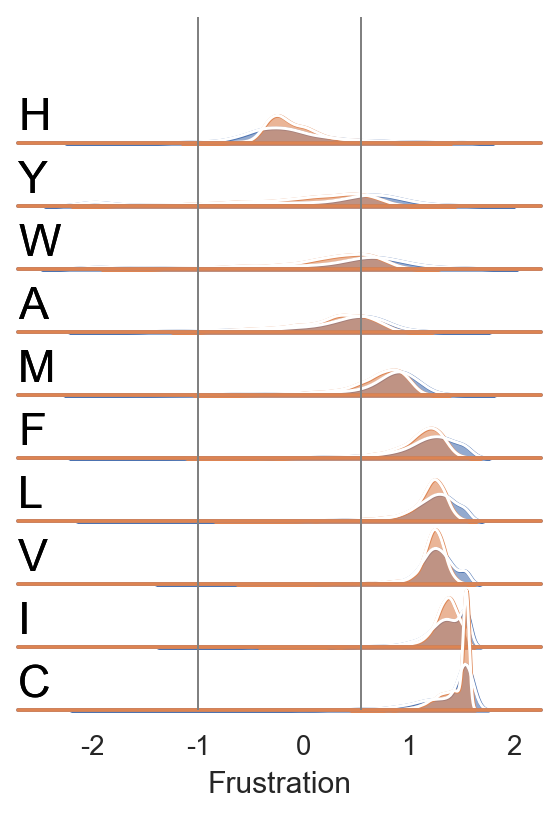

In [20]:
# Color palette for true vs predicted frustration
palette = {"true_reg": "C0", "regr_pred": "C1"}

# --- Ridge plot setup ---
g = sns.FacetGrid(df_melt_2,row="residue",hue="type",aspect=7.5,height=0.5,palette=palette,)

# KDEs
g.map(sns.kdeplot,"frustration",bw_adjust=0.8,clip_on=False,fill=True,alpha=0.6,linewidth=1.5,)

# White outline on top
g.map(sns.kdeplot,"frustration",clip_on=False,color="white",lw=1.2,bw_adjust=0.8,)

# Zero baseline for overlap
g.refline(y=0, linewidth=1.5, linestyle="-", color=None, clip_on=False)

# Optional: Add residue label on each ridge
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

def label_residue(x, color, label):
    ax = plt.gca()
    # Determine which residue corresponds to this axis
    row_i = ax.get_subplotspec().rowspan.start
    residue_name = residues[row_i+10]  # residues is your ordered list
    ax.text(
        0, 0.2, residue_name,
        ha="left", va="center",
        fontsize=18, color="black",
        transform=ax.transAxes
    )

g.map(label_residue, "frustration")

# Optional: Add vertical threshold lines & mean lines
def add_lines(x, color, label):
    ax = plt.gca()
    res = label  # because FacetGrid passes residue as "label"

    # thresholds
    ax.axvline(-1, color="gray", linestyle="-", linewidth=0.7)
    ax.axvline(0.55, color="gray", linestyle="-", linewidth=0.7)

    # mean true frustration for this residue
    #mean_val = reg_dict[res]["mean"]
    #ax.axvline(mean_val, color="blue", linestyle="--", linewidth=1)

g.map(add_lines, "frustration")

# Formatting
g.figure.subplots_adjust(hspace=-0.5)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="Frustration", xticks=np.arange(-2, 3, 1), xticklabels=[-2, -1, 0, 1, 2])
g.despine(bottom=True, left=True)
g.figure.set_dpi(180)

plt.show()

### FIG 3

In [5]:
test_set.keys()

dict_keys(['full_seqs', 'masks', 'regr_preds', 'cls_preds', 'regr_targets', 'cls_targets', 'masked_regr_preds', 'masked_cls_preds', 'masked_regr_targets', 'masked_cls_targets', 'cls_preds_logits', 'masked_cls_preds_logits', 'masked_residues'])

In [6]:
entropies = entropy(softmax(test_set["masked_cls_preds_logits"], axis=-1), axis=-1)
entropies_norm = entropies / np.log(3) # normalize by max entropy for 3 classes
entropies.shape, entropies_norm.shape

((9736349,), (9736349,))

In [7]:
correct_mask = test_set["masked_cls_preds"] == test_set["masked_cls_targets"]
correct_mask

array([ True,  True,  True, ...,  True,  True,  True], shape=(9736349,))

In [8]:
correct_cls0_mask = (test_set["masked_cls_targets"] == 0) & correct_mask
correct_cls1_mask = (test_set["masked_cls_targets"] == 1) & correct_mask
correct_cls2_mask = (test_set["masked_cls_targets"] == 2) & correct_mask
incorrect_cls0_mask = (test_set["masked_cls_targets"] == 0) & ~correct_mask
incorrect_cls1_mask = (test_set["masked_cls_targets"] == 1) & ~correct_mask
incorrect_cls2_mask = (test_set["masked_cls_targets"] == 2) & ~correct_mask

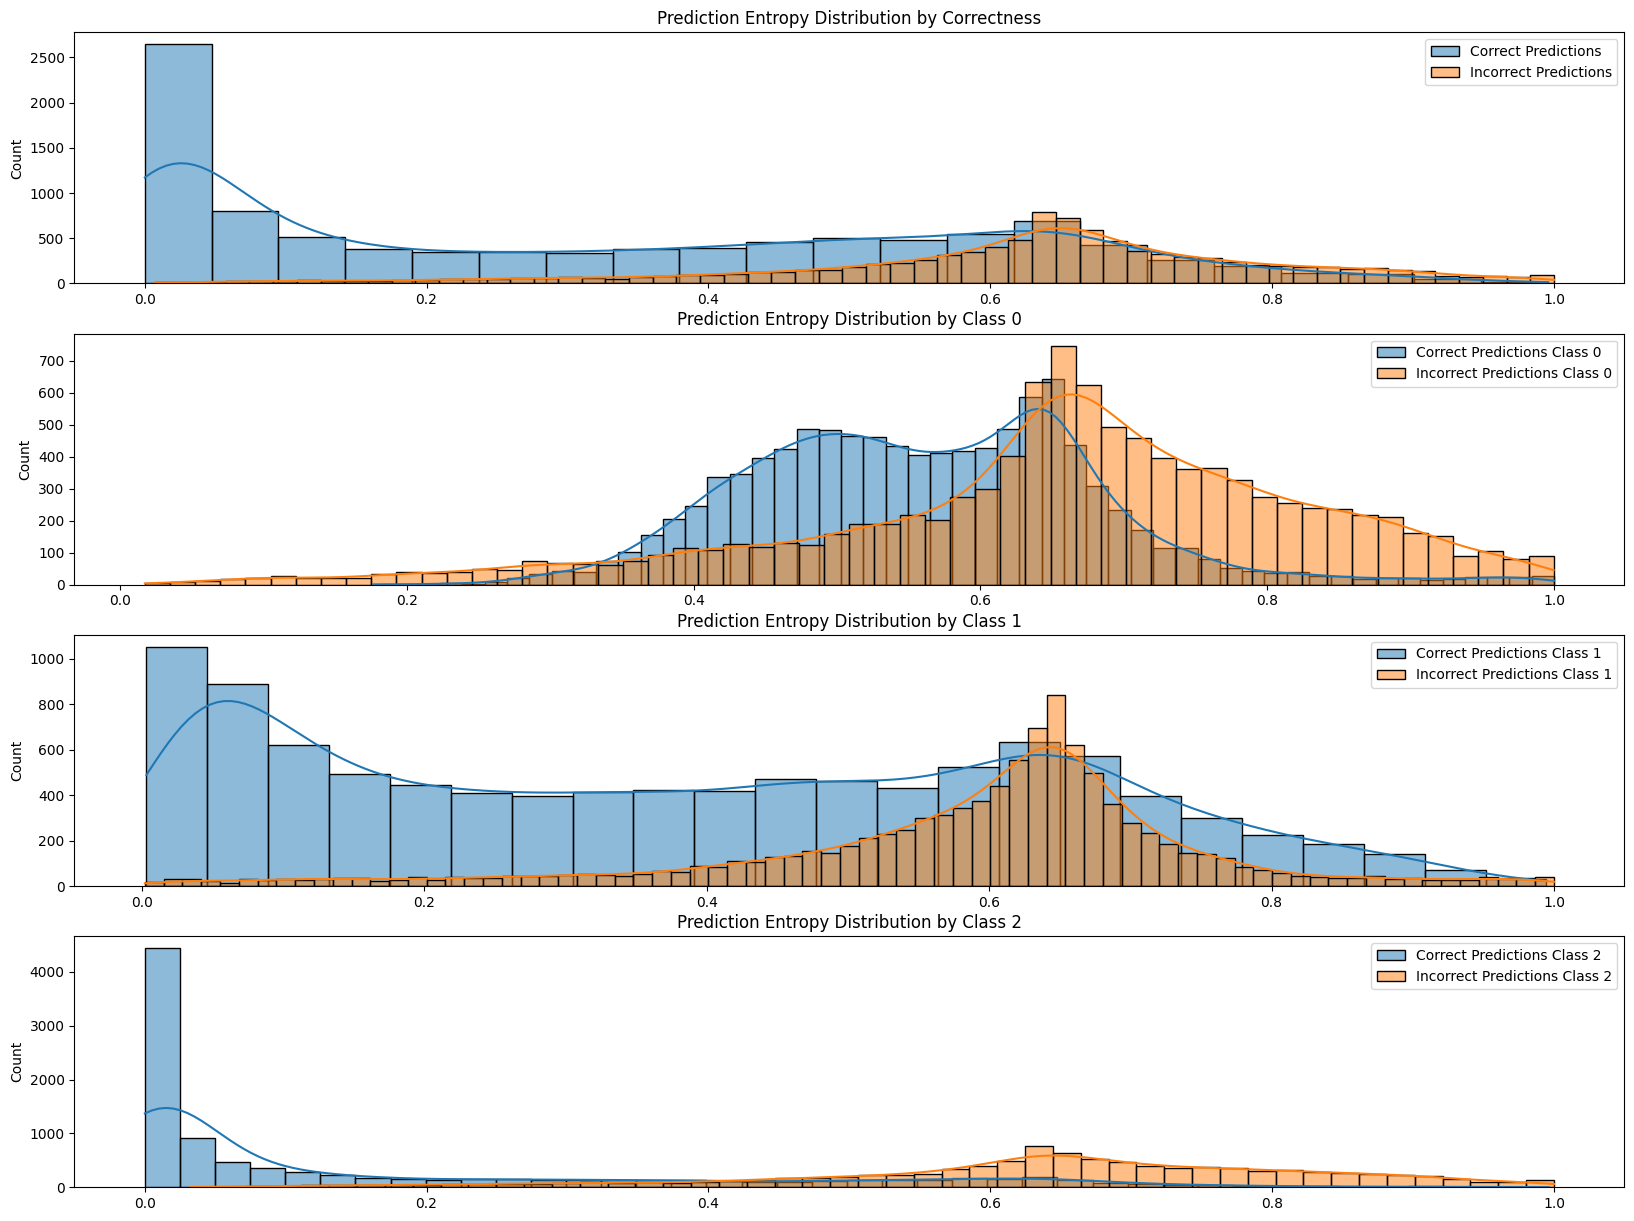

In [9]:
fig, axes = plt.subplots(4, 1, figsize=(20, 15))

sns.histplot(entropies_norm[correct_mask][:10000], kde=True, label='Correct Predictions', ax=axes[0])
sns.histplot(entropies_norm[~correct_mask][:10000], kde=True, label='Incorrect Predictions', ax=axes[0])
axes[0].legend()
axes[0].set_title('Prediction Entropy Distribution by Correctness')

for cls in range(3):
    sns.histplot(entropies_norm[(test_set["masked_cls_targets"] == cls) & correct_mask][:10000], kde=True, label=f'Correct Predictions Class {cls}', ax=axes[cls+1])
    sns.histplot(entropies_norm[(test_set["masked_cls_targets"] == cls) & ~correct_mask][:10000], kde=True, label=f'Incorrect Predictions Class {cls}', ax=axes[cls+1])
    axes[cls+1].legend()
    axes[cls+1].set_title(f'Prediction Entropy Distribution by Class {cls}')
plt.show()

In [43]:
N = test_set["masked_cls_preds"].shape[0]

precisions = []
recalls = []
coverages = []
accepted_counts = []
for t in np.arange(0.05, 1.05, 0.05):
        mask = entropies_norm <= t
        rep_t = classification_report(test_set["masked_cls_targets"][mask], test_set["masked_cls_preds"][mask], digits=4)
        print(rep_t)
        k = mask.sum()
        accepted_counts.append(int(k))
        coverage = k / float(N)
        coverages.append(coverage)
        if k == 0:
            precisions.append(np.nan)   # no accepted samples
            recalls.append(0.0)
        else:
            n_correct = correct_mask[mask].sum()
            prec = n_correct / float(k) # precision = TP / (TP + FP)
            rec = n_correct / float(N) # recall = TP / (TP + FN)
            precisions.append(float(prec))
            recalls.append(float(rec))

/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       586
           1     0.9978    0.9881    0.9929    480687
           2     0.9967    0.9997    0.9982   1725091

    accuracy                         0.9969   2206364
   macro avg     0.6648    0.6626    0.6637   2206364
weighted avg     0.9966    0.9969    0.9968   2206364



/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      3496
           1     0.9926    0.9852    0.9889    892702
           2     0.9932    0.9983    0.9958   1985793

    accuracy                         0.9931   2881991
   macro avg     0.6620    0.6612    0.6616   2881991
weighted avg     0.9918    0.9931    0.9924   2881991



/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/janleusch/anaconda3/envs/biotrainer/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      7007
           1     0.9876    0.9826    0.9851   1175835
           2     0.9903    0.9963    0.9933   2140858

    accuracy                         0.9893   3323700
   macro avg     0.6593    0.6596    0.6595   3323700
weighted avg     0.9872    0.9893    0.9883   3323700

              precision    recall  f1-score   support

           0     0.8889    0.0014    0.0028     11379
           1     0.9822    0.9799    0.9810   1405099
           2     0.9873    0.9937    0.9905   2257078

    accuracy                         0.9853   3673556
   macro avg     0.9528    0.6583    0.6581   3673556
weighted avg     0.9850    0.9853    0.9838   3673556

              precision    recall  f1-score   support

           0     0.9512    0.0210    0.0411     17603
           1     0.9762    0.9770    0.9766   1617914
           2     0.9839    0.9905    0.9872   2355980

    accuracy        

In [10]:
# Inputs you must already have:
# masked_cls_preds: (N,) predicted class labels
# masked_cls_true:  (N,) true class labels
# correct_mask:     (N,) boolean array -> masked_cls_preds == masked_cls_true
# entropies_norm:   (N,) normalized entropy in [0,1]

N = test_set["masked_cls_preds"].shape[0]
classes = [0, 1, 2]

# global metrics
precisions = []
recalls = []
coverages = []
accepted_counts = []

# per-class metrics
precisions_per_class = {c: [] for c in classes}
recalls_per_class = {c: [] for c in classes}

for t in np.arange(0.05, 1.05, 0.05):
    mask = entropies_norm <= t # accepted samples
    k = mask.sum() # number of accepted samples
    accepted_counts.append(int(k))
    coverage = k / float(N)
    coverages.append(coverage)

    if k == 0:
        # global
        precisions.append(np.nan)
        recalls.append(0.0)

        # per class: append NaN
        for c in classes:
            precisions_per_class[c].append(np.nan)
            recalls_per_class[c].append(0.0)
        continue

    # ---------- Global selective precision & recall ----------
    correct = correct_mask.astype(int)

    prec_global = correct[mask].sum() / float(k)
    rec_global = correct[mask].sum() / float(N)

    precisions.append(float(prec_global))
    recalls.append(float(rec_global))

    # ---------- Per-class selective precision & recall ----------
    preds = test_set["masked_cls_preds"]
    truth = test_set["masked_cls_targets"]

    for c in classes:
        # class-specific mask restricted to accepted set
        mask_c = mask & (preds == c)
        k_c = mask_c.sum()

        if k_c == 0:
            # Nobody predicted class c among accepted samples
            precisions_per_class[c].append(np.nan)
        else:
            # precision_c = correct predictions of c / predictions of c
            prec_c = np.sum((preds == c) & (truth == c) & mask) / float(k_c)
            precisions_per_class[c].append(float(prec_c))

        # recall_c = correct predictions of c among accepted samples / total true class c in full dataset
        total_true_c = np.sum(truth == c)
        if total_true_c == 0:
            # no real instances of class c in dataset
            recalls_per_class[c].append(np.nan)
        else:
            rec_c = np.sum((preds == c) & (truth == c) & mask) / float(total_true_c)
            recalls_per_class[c].append(float(rec_c))


In [11]:
recalls_per_class["macro"] = (np.array(recalls_per_class[0]) + np.array(recalls_per_class[1]) + np.array(recalls_per_class[2])) / 3.0
precisions_per_class["macro"] = (np.array(precisions_per_class[0]) + np.array(precisions_per_class[1]) + np.array(precisions_per_class[2])) / 3.0

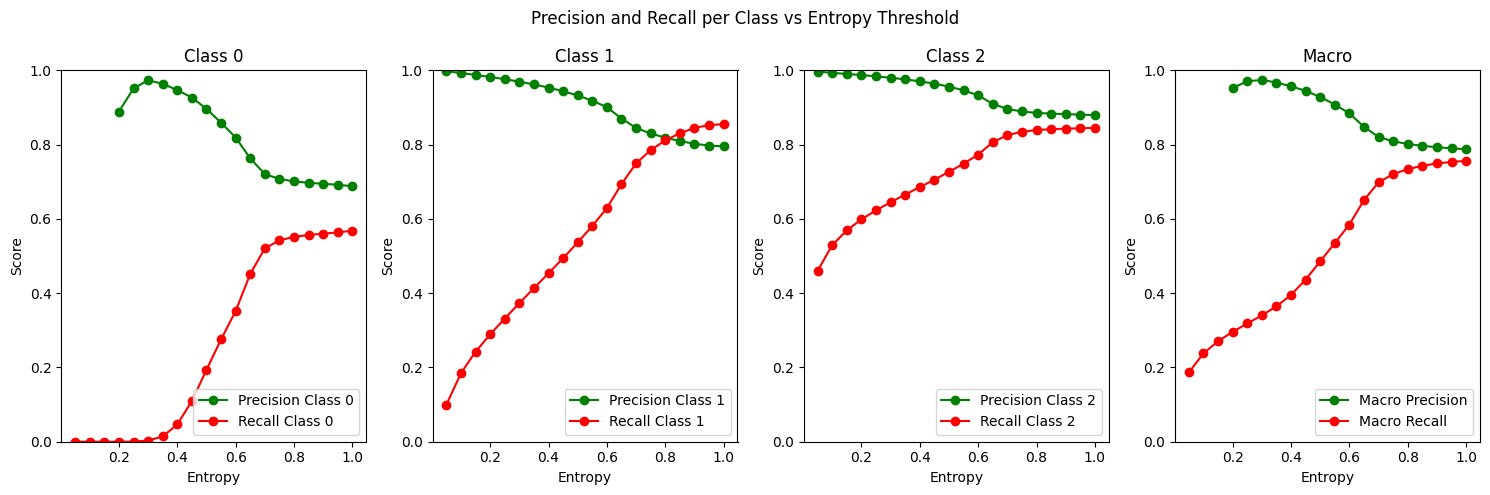

In [12]:
# fig with 3 subplots
fig, ax = plt.subplots(ncols=4, figsize=(15, 5))

for i in range(3):
    cls = i
    ax[i].plot(np.arange(0.05,1.05,0.05), precisions_per_class[cls], 'o-', color="green", label=f"Precision Class {cls}")
    ax[i].plot(np.arange(0.05,1.05,0.05), recalls_per_class[cls], 'o-', color="red", label=f"Recall Class {cls}")
    ax[i].set_ylim(0, 1)
    ax[i].set_xlabel('Entropy')
    ax[i].set_ylabel('Score')
    ax[i].set_title(f'Class {cls}')
    ax[i].legend(loc='lower right')

ax[3].plot(np.arange(0.05,1.05,0.05), precisions_per_class["macro"], 'o-', color="green", label="Macro Precision")
ax[3].plot(np.arange(0.05,1.05,0.05), recalls_per_class["macro"], 'o-', color="red", label="Macro Recall")
ax[3].set_ylim(0, 1)
ax[3].set_xlabel('Entropy')
ax[3].set_ylabel('Score')
ax[3].set_title('Macro')
ax[3].legend(loc='lower right')

plt.suptitle('Precision and Recall per Class vs Entropy Threshold')
plt.tight_layout()
plt.show()